In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from neuroanalysis.data import TSeriesList
import matplotlib.pyplot as plt
from matplotlib import gridspec
from aisynphys.dynamics import sorted_pulse_responses, pulse_response_query
from aisynphys.data import PulseResponseList
from neuroanalysis.baseline import float_mode
from collections import OrderedDict
from aisynphys.ui.notebook import show_connectivity_matrix, plot_stim_sorted_pulse_amp
from aisynphys.connectivity import measure_connectivity, pair_was_probed
import matplotlib.colors, matplotlib.cm
from aisynphys.avg_response_fit import sort_responses, response_query
from neuroanalysis.fitting import Psp, StackedPsp
import seaborn as sns
import pandas as pd
from aisynphys.ui.scalebars import add_scalebar
matplotlib.rcParams['font.sans-serif'] = "Arial"

db = SynphysDatabase.load_current('medium')
#from aisynphys.database import default_db as db
print(db.schema_version)

[5, 9]
21


### Summary statistics

In [2]:
projects = ['mouse V1 coarse matrix', 'mouse V1 pre-production', 'human coarse matrix']

expts = db.query(db.Experiment).filter(db.Experiment.project_name.in_(projects)).all()

expt_counts = {}
slices = set()
for expt in expts:
    slice_id = expt.slice.id
    slic = 1 if slice_id not in slices else 0
    species = expt.slice.species
    age = expt.slice.age
    pairs = expt.pair_list
    data_counts = {
        'expt_id': expt.ext_id,
        'slice_id': slice_id,
        'slices': slic,
        'experiments': 1,
        'species': species,
        'age': age,
        'cells_recorded': 0,
        'ex_pairs_probed': 0,
        'in_pairs_probed': 0,
        'ex_synapses': 0,
        'in_synapses': 0,
        'epsps': 0,
        'epscs': 0,
        'ipsps': 0,
        'ipscs': 0,
        'gap_junctions': 0,
        'poly_syn': 0,
    }
    recorded_cells = []
    for pair in pairs:
        probe_type = pair.pre_cell.cell_class_nonsynaptic
        if probe_type not in ['ex', 'in']:
            continue
        pair_probed = pair_was_probed(pair, probe_type)
        if pair_probed:
            data_counts['%s_pairs_probed'%probe_type] += 1
            recorded_cells.extend([pair.pre_cell, pair.post_cell])
        syn_type = pair.pre_cell.cell_class
        if syn_type not in ['ex', 'in']:
            continue
        if syn_type is not None and pair.has_synapse: 
            data_counts['%s_synapses'%syn_type] += 1
            prs = pair.pulse_responses
            qc_field = '%s_qc_pass' % syn_type
            data_counts['%spsps'%syn_type[0]] += len([pr for pr in prs if getattr(pr, qc_field) is True and 
                                        pr.recording.patch_clamp_recording.clamp_mode=='ic'])
            data_counts['%spscs'%syn_type[0]] += len([pr for pr in prs if getattr(pr, qc_field) is True and 
                                        pr.recording.patch_clamp_recording. clamp_mode=='vc'])
        if pair.has_electrical:
            data_counts['gap_junctions'] +=1
        if pair.has_polysynapse:
            data_counts['poly_syn'] += 1
    data_counts['cells_recorded'] = len(set(recorded_cells))
    if data_counts['cells_recorded'] > 0:
        expt_counts[expt.ext_id] = data_counts
        slices.add(slice_id)    

In [18]:
df = pd.DataFrame.from_dict(expt_counts, orient='index')
columns = [
    'slices',
    'experiments',
    'cells_recorded',
    'ex_pairs_probed',
    'in_pairs_probed',
    'ex_synapses',
    'in_synapses',
    'gap_junctions',
    'poly_syn',
    'epsps',
    'epscs',
    'ipsps',
    'ipscs',
]

df.head()
summary = df.groupby('species').sum()[columns]
summary

# Note: slice counts published in Campagnola, Seeman 2022 differ due to a bug that was fixed after publication.

,slices,experiments,cells_recorded,ex_pairs_probed,in_pairs_probed,ex_synapses,in_synapses,gap_junctions,poly_syn,epsps,epscs,ipsps,ipscs
species,,,,,,,,,,,,,
human,132,216,928,2445,226,181,24,0,74,79162,36641,4851,2123
mouse,1604,1715,7015,9808,11141,533,993,174,2,214739,73421,401379,87623


In [4]:
df.groupby(['species', 'cells_recorded']).sum()

slice_id  slices  experiments     age  \
species cells_recorded                                          
human   2                  44283      26           31  433620   
        3                  64429      26           47  628895   
        4                  77224      36           55  667950   
        5                  48736      21           33  452600   
        6                  33720       8           20  252580   
        7                  39907      11           20  287985   
        8                  18123       4           10  128845   
mouse   2                 401912     251          265   12262   
        3                 559136     392          418   19048   
        4                 573374     382          415   19135   
        5                 462678     281          303   14000   
        6                 277725     175          185    8630   
        7                 133016      82           86    3938   
        8                  71767      41           43    1991   

                        ex_pairs_probed  in_pairs_probed  ex_synapses  \
species cells_recorded                                                  
human   2                            45                2            5   
        3                           187               18           22   
        4                           398               43           26   
        5                           425               55           28   
        6                           420               26           24   
        7                           543               62           37   
        8                           427               20           39   
mouse   2                           187              269           17   
        3                           794             1229           37   
        4                          1955             1973           87   
        5                          2214             2756          142   
        6                          2377             2209          146   
        7                          1271             1775           68   
        8                          1010              930           36   

                        in_synapses  epsps  epscs  ipsps  ipscs  \
species cells_recorded                                            
human   2                         1   2366    900    382     60   
        3                         1   8010   4040      0      5   
        4                         9   9817   4930   2468   1025   
        5                         5  11730   6196    408    192   
        6                         3  11097   3565    656    180   
        7                         4  18815   7543    937    361   
        8                         1  17327   9467      0    300   
mouse   2                        30   4879   2056  12187   2622   
        3                       136  15885   4900  63943  13486   
        4                       151  33873  13088  62101  12801   
        5                       270  57332  19451  98655  21418   
        6                       195  63190  19116  76926  17517   
        7                       143  27947   8165  59271  14892   
        8                        68  11633   6645  28296   4887   

                        gap_junctions  poly_syn  
species cells_recorded                           
human   2                           0         2  
        3                           0         2  
        4                           0         6  
        5                           0        10  
        6                           0        11  
        7                           0        30  
        8                           0        13  
mouse   2                           8         0  
        3                          17         2  
        4                          23         0  
        5                          73         0  
        6                          23         0  
        7                          24    

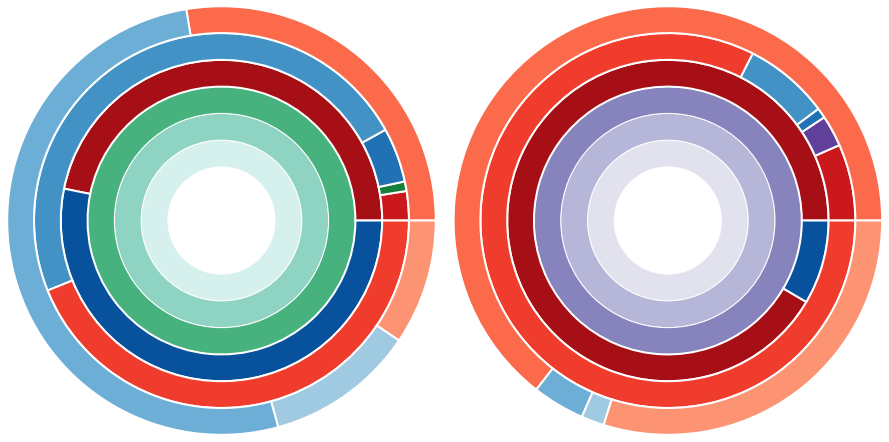

In [5]:
size = 0.3


blues = sns.color_palette("Blues_r", n_colors=7)
reds = sns.color_palette("Reds_r", n_colors=7)
purples = sns.color_palette("Purples", n_colors=4)
blue_greens = sns.color_palette("BuGn", n_colors=4)

stats = {
    'mouse': {
        'slices': blue_greens[0],
        'experiments': blue_greens[1],
        'cells_recorded': blue_greens[2],
        ('ex_pairs_probed', 'in_pairs_probed'): (reds[0], blues[0]),
        ('ex_synapses', 'gap_junctions', 'in_synapses', 'in_unconnected', 'ex_unconnected'): 
        (reds[1], blue_greens[3], blues[1], blues[2], reds[2]),
        ('epsps', 'ipsps', 'ipscs', 'epscs'): (reds[3], blues[3], blues[4], reds[4])
    },
    
    'human': {
        'slices': purples[0],
        'experiments': purples[1],
        'cells_recorded': purples[2],
        ('ex_pairs_probed', 'in_pairs_probed'): (reds[0], blues[0]),
        ('ex_synapses', 'poly_syn', 'in_synapses', 'in_unconnected', 'ex_unconnected'): 
        (reds[1], purples[3], blues[1], blues[2], reds[2]),
        ('epsps', 'ipsps', 'ipscs', 'epscs'): (reds[3], blues[3], blues[4], reds[4])
    }
}

pie_fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=1)

for i, species in enumerate(['mouse', 'human']):
    ax = axs[i]
    data = summary.loc[species]
    data['ex_unconnected'] = data['ex_pairs_probed'] - data['ex_synapses']
    data['in_unconnected'] = data['in_pairs_probed'] - data['in_synapses']
    species_stats = stats[species]
    r = 3
    for stat, color in species_stats.items():
        if isinstance(stat, str):
            wedge_props = dict(width=0.3, edgecolor='w', linewidth=1)
            ax.pie([data[stat]], radius=size*r, wedgeprops=wedge_props, colors=[color])
            r+=1
        elif isinstance(stat, tuple):
            wedge_props = dict(width=0.3, edgecolor='w', linewidth=2)
            d = []
            for s in stat:
                d.append(data[s])
            ax.pie(d, radius=size*r, wedgeprops=wedge_props, colors=color)
            r+=1

In [6]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_pie.svg')
pie_fig.savefig(fname)

12


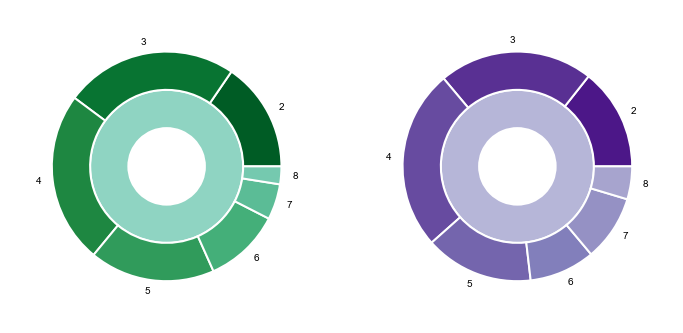

In [9]:
df_copy = df.copy()
df_copy = df_copy[df_copy['cells_recorded']>0]
octo = df_copy.groupby(['species', 'cells_recorded']).count().reset_index()
wedge_props = dict(width=0.3, edgecolor='w', linewidth=2)

octo_fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.1)

for i, species in enumerate(['mouse', 'human']):
    ax = axs[i]
    all_expts = summary.loc[species]['experiments']
    color = stats[species]['experiments']
    data = octo[octo['species']==species]
    cell_expts = data['experiments']
    cell_count = data['cells_recorded']
    if species=='mouse':
        colors = sns.color_palette("BuGn_r", n_colors=12)
        print(len(colors))
    elif species=='human':
        colors = sns.color_palette("Purples_r", n_colors=12)
    ax.pie([all_expts], radius=0.6, wedgeprops=wedge_props, colors=[color])
    ax.pie(cell_expts, radius=0.9, wedgeprops=wedge_props, labels=cell_count, colors=colors)

In [10]:
octo[['species', 'cells_recorded', 'experiments']]

,species,cells_recorded,experiments
0,human,2,31
1,human,3,47
2,human,4,55
3,human,5,33
4,human,6,20
5,human,7,20
6,human,8,10
7,mouse,2,265
8,mouse,3,418
9,mouse,4,415


In [11]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_octo.svg')
octo_fig.savefig(fname)

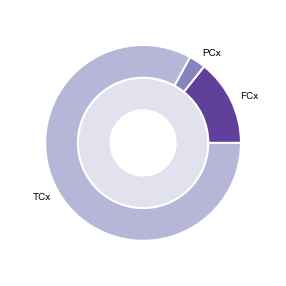

In [13]:
human_df = db.query(db.Experiment.slice_id, db.Experiment.target_region).filter(db.Experiment.project_name=='human coarse matrix').dataframe(rename_columns=False)
human_region = human_df.set_index('slice_id', inplace=False)
human_region = human_region[~human_region.index.duplicated()]
human_region = human_region[human_region['target_region']!= ''].reset_index()
human_region_count = human_region.groupby('target_region').count().reset_index()

region_fig, ax = plt.subplots(1, 1, figsize=(5, 5))

_ = ax.pie([summary.loc['human']['slices']], radius=0.6, wedgeprops=wedge_props, colors=[stats['human']['slices']])
_ = ax.pie(human_region_count['slice_id'], radius=0.9, wedgeprops=wedge_props, colors=sns.color_palette("Purples_r", n_colors=4),
       labels=human_region_count['target_region'])

In [14]:
human_region_count

,target_region,slice_id
0,FCx,26
1,PCx,5
2,TCx,151


In [15]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_region.svg')
region_fig.savefig(fname)

ValueError: x must be 1D

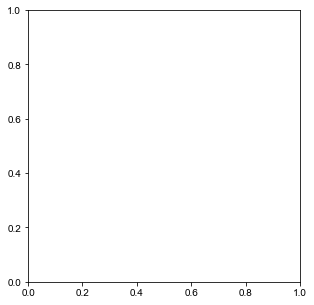

In [16]:
from aisynphys.genotypes import Genotype
from collections import OrderedDict
import pandas as pd
slices = db.query(db.Slice).join(db.Experiment).filter(db.Experiment.project_name.in_(['mouse V1 pre-production', 'mouse V1 coarse matrix'])).all()
cres = OrderedDict([
    ('nr5a1', 0),
    ('rorb', 0),
    ('sim1', 0),
    ('fam84b', 0),
    ('tlx3', 0),
    ('ntsr1', 0),
    ('pvalb', 0),
    ('sst', 0),
    ('vip', 0)
])

for slic in slices:
    geno = Genotype(slic.genotype)
    drivers = geno.all_drivers
    for driver in drivers:
        if driver not in cres.keys():
            continue
        cres[driver]+=1
cres_df = pd.DataFrame(cres, index=[0])
inhib = sum([cres_df['pvalb'], cres_df['sst'], cres_df['vip']])
i_colors = sns.color_palette("Blues_r", n_colors=5)
exc = cres_df.sum().sum() - inhib
e_colors = sns.color_palette("Reds_r", n_colors=8)
explode = (0.1, 0.1, 0.15, 0.15, 0.15, 0.1) + (0,)*3

cre_fig, ax = plt.subplots(figsize=(5, 5))
# _ = ax.pie(summary.loc['mouse']['slices'], radius=0.6, wedgeprops=wedge_props, colors=[stats['mouse']['slices']])
_ = ax.pie([inhib, exc], radius=0.6, wedgeprops=dict(width=0.2, edgecolor='w'), colors=[i_colors[0], e_colors[0]])
_ = ax.pie(cres_df, radius=0.9, wedgeprops=wedge_props, colors=e_colors[1:7]+i_colors[1:], labels=cres_df.columns, explode=explode)

In [ ]:
cres_df

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_cre.svg')
cre_fig.savefig(fname)

In [ ]:
slices = df.copy()
slices.set_index('slice_id', inplace=True)
slices = slices[~slices.index.duplicated()]
slices = slices[slices['age'] > 0]
slices.loc[slices.species=='human', 'age'] /= 365
print(slices.groupby('species')['age'].describe(percentiles=[0.5]))
age_fig, ax = plt.subplots(1, 1)
sns.violinplot(x='species', y='age', data=slices, inner=None, ax=ax, order=['mouse', 'human'], cut=0)
ax.set_ylabel('Age (days)')
# sns.stripplot(x='species', y='age', data=ages, ax=ax, color='k', alpha=0.5, jitter=0.2)
ax2 = ax.twinx()
sns.violinplot(x='species', y='age', data=slices, ax=ax2, order=['mouse', 'human'], cut=0)
ax2.set_ylabel('Age (years)', rotation=-90)

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_ages.svg')
age_fig.savefig(fname)

#### Load up an Experiment from the Database.

In [ ]:
expt_id = '1556746729.253' #'1555444699.177'
expt = db.query(db.Experiment).filter(db.Experiment.ext_id == expt_id).all()[0]
n_cells = len(expt.cells)
pairs = expt.pairs
n_cnx_probed = len(pairs)
n_cnx_found = len([pair for pair in expt.pairs.values() if pair.has_synapse is True])
print('Number of cells recorded: %d' % n_cells)
print('Number of connections probed: %d' % n_cnx_probed)
print('Number of connections found: %d' % n_cnx_found)

### For example pairs, plot all trials of one stimulus set along with the average

In [ ]:
e_pair = expt.pairs[('1', '3')] #(2, 3)
e_color = (0, 0, 1) #(0,1, 0)
i_pair = expt.pairs[('5', '1')] #(3, 7)
i_color = (0, 1, 0) #(1, 0,0)

freq = 50.0
delay = 0.25
e_electrode = e_pair.post_cell.electrode
i_electrode = i_pair.post_cell.electrode
spike_id = i_pair.pre_cell.electrode.device_id

fig = plt.figure(figsize=(15,8))
grid = gridspec.GridSpec(4, 1, height_ratios=[0.2,0.5,1,1])
ax_stim = fig.add_subplot(grid[0])
ax_spike = fig.add_subplot(grid[1])
ax_e = fig.add_subplot(grid[2])
ax_i = fig.add_subplot(grid[3])
axes = [ax_stim, ax_spike, ax_e, ax_i]
[axi.spines['right'].set_visible(False) for axi in axes]
[axi.spines['top'].set_visible(False) for axi in axes]
[axi.spines['bottom'].set_visible(False) for axi in axes[:3]]
[axi.get_xaxis().set_visible(False) for axi in axes[:3]]

sweeps = expt.sync_recs
rec_sweeps = []
e_sweeps = []
i_sweeps = []
for sweep in sweeps:
    mpp = sweep.recordings[0].patch_clamp_recording.multi_patch_probe
    if mpp is None:
        continue
    ind_freq = mpp.induction_frequency
    rec_delay = round(mpp.recovery_delay, 2)
    if ind_freq==freq and rec_delay==delay:
        rec_sweeps.append(sweep)
        
for sweep in rec_sweeps[:5]:
    e_rec = [rec for rec in sweep.recordings if rec.electrode_id==e_electrode.id]
    i_rec = [rec for rec in sweep.recordings if rec.electrode_id==i_electrode.id]
    sweep_id = sweep.ext_id
    if len(e_rec)>0:
        e_rec = e_rec[0]
        e_holding = e_rec.patch_clamp_recording.baseline_potential
        if e_holding > -80e-3 and e_holding < -60e-3:
            e_data = expt.data.contents[sweep_id][e_electrode.device_id]['primary']
            e_sweeps.append(e_data)
            ax_e.plot(e_data.time_values, e_data.data, color=(0.1,0.1,0.1,0.2))
            spike_data = expt.data.contents[sweep_id][spike_id]['primary']
            ax_spike.plot(spike_data.time_values, spike_data.data, color=(0,0,0,0.5))
    if len(i_rec)>0:
        i_rec = i_rec[0]
        i_holding = i_rec.patch_clamp_recording.baseline_potential
        if i_holding > -60e-3 and i_holding < -45e-3:
            i_data = expt.data.contents[sweep_id][i_electrode.device_id]['primary']
            i_sweeps.append(i_data)
            ax_i.plot(i_data.time_values, i_data.data, color=(0.1,0.1,0.1,0.2))
         
e_list = TSeriesList(e_sweeps)
e_avg = e_list.mean()
ax_e.plot(e_avg.time_values, e_avg.data, color=e_color, linewidth=3)
i_list = TSeriesList(i_sweeps)
i_avg = i_list.mean()
ax_i.plot(i_avg.time_values, i_avg.data, color=i_color, linewidth=3)
stim = expt.data.contents[sweep_id][spike_id]['command']
ax_stim.plot(stim.time_values, stim.data, color='k')
ax_e.set_xlim(0.995, 1.595) # ax_e.set_xlim(0.992, 1.592)
ax_spike.set_xlim(3.82, 4.42)# ax_spike.set_xlim(1.7, 2.3)
ax_stim.set_xlim(1.7, 2.3) # ax_stim.set_xlim(1.7, 2.3)
ax_i.set_xlim(5.9, 6.5) # ax_i.set_xlim(1.7, 2.3)
ax_e.set_ylim(-72e-3, -61e-3) #ax_e.set_ylim(-71e-3, -67.5e-3)
ax_i.set_ylim(-56e-3, -51e-3)

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1B_traces_raw.svg')
fig.savefig(fname)

In [ ]:


cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'target_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'target_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'target_layer': '2/3'},
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}
cell_groups = classify_cells(cell_classes.values(), pairs=expt.pair_list)
pair_groups = classify_pairs(expt.pair_list, cell_groups)
connectivity_results = measure_connectivity(pair_groups)

norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

class_labels = {
    'l23pyr': 'L2/3 Pyr\nspiny',
    'l23pv':  'L2/3 Pv',
    'l23sst': 'L2/3 Sst',
}

fig, ax = plt.subplots(figsize=(5, 5))
plt.rc('font', size=20)

im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=connectivity_results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm,
    alpha=False
)

#### Align all post-synaptic responses to their pre-synaptic spike and separate based on holding potential. -70mV to probe excitatory connections, -55 mV to probe inhibitory connections in both current and voltage clamp. Colorize response base on QC. Average QC-passed responses

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace=.5, wspace=.5)

[axi.set_xlim(-5e-3, 20e-3) for axi in axes.ravel()]

modes = ['vc', 'ic']
s = db.session()
i = 0
for j, pair_hold in enumerate(zip([e_pair, i_pair], [-70, -55])):
    pair = pair_hold[0]
    holding = pair_hold[1]
    records = response_query(session=s, pair=pair)
    prs = [rec[0] for rec in records]
    sort_prs = sort_responses(prs)
    for i, mode in enumerate(modes):
        qc_pass_resp = sort_prs[(mode, holding)]['qc_pass']
        pr_list = PulseResponseList(qc_pass_resp).post_tseries(align='spike', bsub=True)
        for trace in pr_list:
            axes[i,j].plot(trace.time_values, trace.data, color=(0, 0, 0, 0.08))
        if len(qc_pass_resp)>0:
            avg = PulseResponseList(qc_pass_resp).post_tseries(align='spike', bsub=True).mean()
            color = e_color if j==0 else i_color
            axes[i,j].plot(avg.time_values, avg.data, color=color, linewidth=3)

add_scalebar(axes[0, 0], matchx=False, matchy=False, sizey=50e-12, labely='50 pA', loc='lower left')
add_scalebar(axes[1, 0], matchx=False, sizex=10e-3, labelx='10 ms', matchy=False, sizey=2e-3, labely='2 mV', loc='lower left')
add_scalebar(axes[1, 1], matchx=False, sizex=10e-3, labelx='10 ms', matchy=False, sizey=0.5e-3, labely='0.5 mV', loc='lower left')
add_scalebar(axes[0, 1], matchx=False, matchy=False, sizey=5e-12, labely='5 pA', loc='lower left')
        

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'process_traces.svg')
fig.savefig(fname)

#### Fit Average Response

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace=.5, wspace=.5)

[axi.set_xlim(-5e-3, 20e-3) for axi in axes.ravel()]

modes = ['vc', 'ic']
s = db.session()

for j, pair_hold in enumerate(zip([e_pair, i_pair], [-70, -55])):
    pair = pair_hold[0]
    holding = pair_hold[1]
    records = response_query(session=s, pair=pair)
    prs = [rec[0] for rec in records]
    sort_prs = sort_responses(prs)
    for i, mode in enumerate(modes):
        responses= sort_prs[(mode, holding)]['qc_pass']
        pr_list = PulseResponseList(responses).post_tseries(align='spike', bsub=True)
        avg_response = pr_list.mean()
        color = e_color +(0.5,) if j==0 else i_color +(0.5,)
        axes[i,j].plot(avg_response.time_values, avg_response.data, color=color, linewidth=5)
#         axes[i,j].spines['right'].set_visible(False)
#         axes[i,j].spines['top'].set_visible(False)
        
        fit = [f for f in pair.synapse.avg_response_fits if (f.clamp_mode==mode and f.holding==holding)][0]
        if mode == 'ic':
            p = StackedPsp()
        if mode == 'vc':
            p = Psp()
        fit_params = {
            'decay_tau': fit.fit_decay_tau,
            'xoffset': fit.fit_xoffset,
            'yoffset': fit.fit_yoffset,
            'amp': fit.fit_amp,
            'rise_time': fit.fit_rise_time,
            'rise_power': 2.0,
            'exp_amp': fit.fit_exp_amp,
            'exp_tau': fit.fit_exp_tau
        }
        fit_psp = p.eval(x=avg_response.time_values, **fit_params)
        fit_tseries = avg_response.copy(data=fit_psp)
        axes[i,j].plot(fit_tseries.time_values, fit_tseries.data, color='k', linewidth=2.5)

add_scalebar(axes[0, 0], matchx=False, matchy=False, sizey=50e-12, labely='50 pA', loc='lower left')
add_scalebar(axes[1, 0], matchx=False, sizex=10e-3, labelx='10 ms', matchy=False, sizey=1e-3, labely='1 mV', loc='lower left')
add_scalebar(axes[1, 1], matchx=False, sizex=10e-3, labelx='10 ms', matchy=False, sizey=0.1e-3, labely='0.1 mV', loc='lower left')
add_scalebar(axes[0, 1], matchx=False, matchy=False, sizey=5e-12, labely='5 pA', loc='lower left')
        

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'analyze_fit.svg')
fig.savefig(fname)

In [ ]:
from aisynphys.dynamics import stim_sorted_pulse_amp
import seaborn as sns
pairs = {e_pair: ([0,8], None), i_pair: ([0,4], [8,12])}
stp_fig,axs = plt.subplots(len(pairs), 1, figsize=(10, 2*len(pairs)))
colors = [e_color, i_color]

for pair_i, (pair, pulses) in enumerate(pairs.items()):
    color = colors[pair_i]
    ax = axs[pair_i]
    
    qc_pass_data = stim_sorted_pulse_amp(pair)

    # scatter plots of event amplitudes sorted by pulse number 
    mask = qc_pass_data['induction_frequency'] == 50
    filtered = qc_pass_data[mask]

    sign = 1 if pair.synapse.synapse_type == 'ex' else -1
    try:
        filtered['dec_fit_reconv_amp'] *= sign * 1000
    except KeyError:
        print('No fit amps for pair: %s' % pair)
    ax.set_ylim(0, filtered['dec_fit_reconv_amp'].max())
    ax.set_xlim(0, 13)

    sns.swarmplot(x='pulse_number', y='dec_fit_reconv_amp', data=filtered, color=(0.7, 0.7, 0.7), size=3, ax=ax)
    
    pulse_median = filtered.groupby('pulse_number').median()['dec_fit_reconv_amp'].to_list()
    ind_pulses = pulses[0]
    if ind_pulses is not None:
        ax.plot(range(ind_pulses[0],ind_pulses[1]), pulse_median[ind_pulses[0]:ind_pulses[1]], 
                color=color, linewidth=2, zorder=100)
    rec_pulses = pulses[1]
    if rec_pulses is not None:
        ax.plot(range(rec_pulses[0], rec_pulses[1]), pulse_median[rec_pulses[0]:rec_pulses[1]], 
                color=color, linewidth=2, zorder=100)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')

stp_fig.text(0.07 , 0.5, 'PSP fit amplitude (mV)', va='center', rotation='vertical', fontsize=12)
stp_fig.text(0.5, 0, 'Pulse Number', ha='center', rotation='horizontal', fontsize=12)
    
#     plot_stim_sorted_pulse_amp(pair, ax[pair_i], color=colors[pair_i])

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1f_stp.svg')
stp_fig.savefig(fname)

In [ ]:
from ipfx.stimulus_protocol_analysis import LongSquareAnalysis
from ipfx.sweep import Sweep, SweepSet
from ipfx.data_set_features import extractors_for_sweeps
from aisynphys.intrinsic_ephys import MPSweep

def get_long_square_features(recordings, cell_id=''):
    errors = []
    if len(recordings) == 0:
        errors.append('No long pulse sweeps for cell %s' % cell_id)
        return {}, errors

    min_pulse_dur = np.inf
    sweep_list = []
    for rec in recordings:
        pulse_times = get_pulse_times(rec)
        if pulse_times is None:
            continue

        # pulses may have different durations as well, so we just use the smallest duration
        start, end = pulse_times
        min_pulse_dur = min(min_pulse_dur, end-start)

        sweep = MPSweep(rec, -start)
        if sweep is not None:
            sweep_list.append(sweep)

    if len(sweep_list) == 0:
        errors.append('No long square sweeps passed qc for cell %s' % cell_id)
        return {}, errors

    sweep_set = SweepSet(sweep_list)    
    spx, spfx = extractors_for_sweeps(sweep_set, start=0, end=min_pulse_dur)
    lsa = LongSquareAnalysis(spx, spfx, subthresh_min_amp=-200)

    try:
        analysis = lsa.analyze(sweep_set)
    except Exception as exc:
        errors.append('Error running long square analysis for cell %s: %s' % (cell_id, str(exc)))
        return {}, errors

    analysis_dict = lsa.as_dict(analysis)
    
    return analysis_dict


In [ ]:
from aisynphys.nwb_recordings import get_intrinsic_recording_dict, get_pulse_times
from neuroanalysis.data.dataset import TSeries
from aisynphys.pipeline.multipatch.intrinsic import IntrinsicPipelineModule
from aisynphys.ui.scalebars import add_scalebar

cell_ext_id = '5'
cells = expt.cells
cell = cells[cell_ext_id]
intrinsic_dict = get_intrinsic_recording_dict(expt.data, int(cell.ext_id)-1)
intrinsic_A = plt.figure(figsize=(7, 5))
grid = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1.5, 1], hspace=0.05, wspace=0.3)
ax_stim = intrinsic_A.add_subplot(grid[0, 0])
ax_resp = intrinsic_A.add_subplot(grid[1, 0])
ax_curve = intrinsic_A.add_subplot(grid[0:, 1:])

for sweeps in intrinsic_dict.values():
    for sweep in sweeps:
        trace = sweep['primary']
        cmd = sweep['command']
        start, stop = get_pulse_times(sweep)
        cmd.t0 = -start
        cmd_base = cmd.time_slice(-0.5, 0).mean()
        trace.t0 = -start
        if 'TargetV' in sweep.stimulus.description:
            ax_stim.plot(cmd.time_values, (cmd.data-cmd_base)*1e12, linewidth=1) 
            ax_resp.plot(trace.time_values, trace.data*1e3,linewidth=1)
            cmd_amp = cmd.time_slice(0, (stop-start)).mean()
#             i.append(cmd_amp*1e12)
            trace_peak = trace.time_slice(0, (stop-start)).mean()
            trace_base = trace.time_slice(-0.5, 0).mean()
            trace_amp = trace_peak - trace_base
#             v.append(trace_amp*1e3)
            ax_curve.plot(trace_amp*1e3, cmd_amp*1e12, marker='o', markersize=10)

ax_stim.set_xlim(-0.5, 1.5)
ax_stim.set_ylim(-55, 10)
add_scalebar(ax_stim, matchx=False, matchy=False, sizey=20, labely='20 pA', loc='lower left')
ax_resp.set_xlim(-0.5, 1.5)
ax_resp.set_ylim(-83, -60)
add_scalebar(ax_resp, matchx=False, sizex=0.5, labelx='0.5 s', matchy=False, sizey=5, labely='5 mV', loc='lower left')

ax_curve.spines['right'].set_visible(False)
ax_curve.spines['top'].set_visible(False)
ax_curve.set_xlabel('pA')
ax_curve.set_xlim(-15, 5)
ax_curve.set_ylim(-75, -10)
ax_curve.set_ylabel('mV')
plt.tight_layout()


In [ ]:
intrinsic_B = plt.figure(figsize=(7, 5))
grid = gridspec.GridSpec(2, 2, height_ratios=[1, 2], hspace=0.05, wspace=0.3, width_ratios=[1.5, 1])
ax_stim = intrinsic_B.add_subplot(grid[0, 0])
ax_resp = intrinsic_B.add_subplot(grid[1, 0])
ax_curve = intrinsic_B.add_subplot(grid[0:, 1:])

z_order = 5
for sweeps in intrinsic_dict.values():
    for sweep in sweeps:
        trace = sweep['primary']
        cmd = sweep['command']
        start, stop = get_pulse_times(sweep)
        cmd.t0 = -start
        cmd_base = cmd.time_slice(-0.5, 0).mean()
        trace.t0 = -start
        if 'If_Curve' in sweep.stimulus.description:
            ax_stim.plot(cmd.time_values, (cmd.data-cmd_base)*1e12, linewidth=1) 
            ax_resp.plot(trace.time_values, trace.data*1e3, linewidth=z_order/2, zorder=z_order, alpha=1-z_order/10)
            z_order += -1
            
ax_stim.set_xlim(-0.2, 0.8)
ax_stim.set_ylim(0, 130)
add_scalebar(ax_stim, matchx=False, matchy=False, sizey=50, labely='50 pA', loc='lower left', bbox_to_anchor=(15, 220))
ax_resp.set_xlim(-0.2, 0.8)
ax_resp.set_ylim(-100, 30)
add_scalebar(ax_resp, matchx=False, sizex=0.5, labelx='0.5 s', matchy=False, sizey=20, labely='20 mV', loc='lower left', bbox_to_anchor=(15, 15))

colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
lp_results = get_long_square_features(intrinsic_dict['LP'], cell_id=cell.id)
spike_times = []
for sweep in lp_results['spiking_sweeps']:
    spike_times.append([spike['peak_t'] for spike in sweep['spikes']])
fi_sorted = sorted(lp_results["spiking_sweeps"], key=lambda s:s['stim_amp'])
x = [d['stim_amp'] for d in fi_sorted]
y = [d['avg_rate'] for d in fi_sorted]
first_nonzero_idx = np.nonzero(y)[0][0]
ax_curve.plot(x[first_nonzero_idx:], 
        lp_results["fi_fit_slope"] * (np.array(x[first_nonzero_idx:]) - x[first_nonzero_idx]) + 8, 
        color='k',linewidth=1)
ax_curve.scatter(x, y, color=colors, s=70)
ax_curve.spines['right'].set_visible(False)
ax_curve.spines['top'].set_visible(False)

y_start = -70
for c, spikes in enumerate(spike_times):
    y = [y_start] * len(spikes)
    ax_resp.scatter(spikes, y, marker='o', s=15)
    y_start += -5

ax_curve.spines['right'].set_visible(False)
ax_curve.spines['top'].set_visible(False)
ax_curve.set_ylabel('Firing rate (spikes/s)')
ax_curve.set_xlabel('pA')

plt.tight_layout()

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_intrinsic_b.svg')
intrinsic_B.savefig(fname)

fname = os.path.join('generated_svg', 'fig1', 'Fig1_intrinsic_a.svg')
intrinsic_A.savefig(fname)

In [ ]:
from pandas.plotting import table
intrinsic = {
    'input resistance (mOhm)': expt.cells[cell_ext_id].intrinsic.input_resistance*1e-6,
    'rheobase (pA)': expt.cells[cell_ext_id].intrinsic.rheobase*1e9,
    'sag': expt.cells['3'].intrinsic.sag,
    'f-i slope (pA)': expt.cells[cell_ext_id].intrinsic.fi_slope*1e9,
    'upstroke/downstroke': expt.cells[cell_ext_id].intrinsic.ap_upstroke_downstroke_ratio,
    'spike width (ms)': expt.cells[cell_ext_id].intrinsic.ap_width*1e3,
}

df = pd.DataFrame.from_dict(intrinsic, orient='index').round(decimals=2)

table_fig, ax = plt.subplots(frameon=False)
ax.axis('off')
ax.axis('tight')
fig.patch.set_visible(False)
white = ['w']
grey = [(0.8, 0.8, 0.8)]
colors = [white, grey, white, grey, white, grey]
df_table = table(ax, df, loc='center', cellColours=colors, rowColours=[c[0] for c in colors])
fig.tight_layout()
df_table.set_fontsize(16)
df_table.scale(1, 1.5)
df_table.auto_set_column_width(col=[0, 1])

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_intrinsic_table.svg')
table_fig.savefig(fname)

In [ ]:
morphology = []

for cell in expt.cell_list:
    morpho = cell.morphology
    ccl = cell.cortical_location
    if morpho.dendrite_type not in ['spiny', 'sparsely spiny', 'aspiny']:
        continue
    m_dict = {
        'Cell': cell.ext_id,
        'Layer': ccl.cortical_layer,
        'Dendrite': morpho.dendrite_type,
        'Axon Length(µm)': '> 200' if morpho.axon_truncation == 'intact' else morpho.axon_trunc_distance
    }
    morphology.append(m_dict)
    
df = pd.DataFrame(morphology)

table_fig, ax = plt.subplots(figsize=(15, 15), frameon=False)
ax.axis('off')
ax.axis('tight')
fig.patch.set_visible(False)
white = ['w'] * 4
grey = [(0.9, 0.9, 0.9)] * 4
colors = [grey, white, grey, white, grey, white, grey]
df_table = table(ax, df, loc='center', cellColours=colors, rowColours=[c[0] for c in colors], cellLoc='center')
fig.tight_layout()
df_table.set_fontsize(24)
df_table.scale(1, 3)
df_table.auto_set_column_width(col=[0, 1, 2, 3])

In [ ]:
fname = os.path.join('generated_svg', 'fig1', 'Fig1_morpho_table.svg')
table_fig.savefig(fname)